In [50]:
%matplotlib inline
import time
import random
import math
import pickle
from collections import namedtuple, defaultdict, Counter

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

# Data Pull

In [99]:
with open('raw_data.txt') as f:
    lines = f.readlines()
lines = [x.strip().split('\t') for x in lines]

name_to_cid = {}
cid_to_name = {}

for row in lines:
    for name in row:
        if name not in name_to_cid:
            name_to_cid[name] = len(name_to_cid)
            cid_to_name[name_to_cid[name]] = name

# Every row of G is a student's "resume", with most recent company first
G = [[name_to_cid[name] for name in reversed(row)] for row in lines]
num_students = len(G)
num_companies = len(name_to_cid)
company_counter = Counter([cid for row in G for cid in set(row)])

cid_to_rows = defaultdict(set)
for i, row in enumerate(G):
    for cid in row:
        cid_to_rows[cid].add(i)
        
num_students, num_companies, G[0], company_counter[name_to_cid['Google']], len(cid_to_rows[name_to_cid['Google']])

(1350, 2370, [3, 2, 1, 0], 72, 72)

In [14]:
def _dcg(r, variant):
    p = r.size
    if variant == 1:
        return r[0] + np.sum(r[1:] / np.log2(np.arange(2, p + 1)))
    else:
        return np.sum((np.exp2(r) - 1.0) / np.log2(np.arange(1, p + 1) + 1.0))

def _ndcg(r, variant):
    sorted_r = np.sort(r)[::-1]
    return _dcg(r, variant) / _dcg(sorted_r, variant)
    
def ndcg(relevances, variant=2):
    '''Calculates NDCG of the relevances array.
    
    Example: if the companies given were [100, 50, 75, 25, 50], then they will be transformed to [4, 2, 3, 1, 2].
    relevances: the companies' relevances in chronological order, recent-first (higher is better).
    
    '''
    assert variant in [1, 2]
    z = {}
    val = 1
    for r in sorted(relevances):
        if r not in z:
            z[r] = val
            val += 1
    ans = [z[r] for r in relevances]
    return _ndcg(np.asfarray(ans), variant)

ndcg([100, 50, 75, 25, 50]), ndcg([1, 2, 3, 4])

(0.97294286597858992, 0.60209052070893998)

In [33]:
def get_relevance(ranking):
    '''Returns a mapping of cid -> relevance, (higher is better).'''
    z = {}
    for i, cid in enumerate(ranking):
        z[cid] = num_companies - i
    return z

def score(ranking):
    '''Sum of the scores.'''
    relevance = get_relevance(ranking)
    scores = [ndcg([relevance[cid] for cid in row]) for row in G]
    _score = sum(scores)
    return _score, scores

def get_partial_relevance(cid_to_rank, cid):
    '''Returns the relevances of companies who are on the same resumes as the given cid.
    
    Essentially, rank and relevance are inversely correlated.
    
    '''
    z = {}
    for row_num in cid_to_rows[cid]:
        for company in G[row_num]:
            if company not in z:
                z[company] = num_companies - cid_to_rank[company]
    return z

def partial_score(cid_to_rank, cid):
    '''Returns the total score of the resumes that contain the given cid.'''
    relevance = get_partial_relevance(cid_to_rank, cid)
    _score = sum(ndcg([relevance[cid] for cid in G[row_num]]) for row_num in cid_to_rows[cid])
    return _score

In [46]:
def get_names(ranking):
    '''Returns the names of the given ranking.'''
    return [cid_to_name[cid] for cid in ranking]

def insert_ranking_test(from_val, to_val, ranking):
    '''Returns a copy of ranking where ranking[from_val] is insert before/after ranking[to_val],
    depending on the relative ordering.
    
    '''
    assert from_val != to_val
    ranking_test = ranking[:]
    v = ranking_test.pop(from_val)
    ranking_test.insert(to_val, v)
    #assert len(set(ranking_test)) == num_companies
    assert len(ranking_test) == num_companies
    return ranking_test

def get_ranking_map(ranking):
    '''Returns a mapping of cid -> rank.'''
    z = {}
    for i, v in enumerate(ranking):
        z[v] = i
    return z

def fast_insert_score(from_val, to_val, cid, ranking_map):
    '''A hack to efficiently calculate score diffs, using the fact that NDCG scores relative ranking only.'''
    assert ranking_map[cid] == from_val
    assert from_val != to_val
    old_partial_score = get_partial_score(ranking_map, cid)
    if to_val < from_val:
        ranking_map[cid] = to_val - 0.5
    else:
        ranking_map[cid] = to_val + 0.5
    new_partial_score = get_partial_score(ranking_map, cid)
    ranking_map[cid] = from_val
    return new_partial_score - old_partial_score
    
def bsearch_low(x, ranking, current_score):
    '''Tries to insert x as close to the top of the ranking using binary search.'''
    ranking_map = get_ranking_map(ranking)
    y_low = 0 #insert before this guy
    y_high = x # non-inclusive

    while y_high - y_low > 1:
        y_mid = (y_low + y_high - 1) // 2 # this rounds closer to y_low
        y_mid = random.randint(y_low, y_mid) # more aggressive, more likely to overshoot

        fast_score = fast_insert_score(x, y_mid, ranking[x], ranking_map)

        if math.isclose(fast_score, 0.0, abs_tol=1e-5):
            y_high = y_mid + 1
        elif fast_score > 0.0:
            ranking_test = insert_ranking_test(x, y_mid, ranking)
            new_score = score(ranking_test)[0]
            assert new_score > current_score
            current_score = new_score
            ranking = ranking_test
            return ranking, current_score
        else:
            y_low = y_mid + 1
            
    if y_low != x:
        ranking_test = insert_ranking_test(x, y_low, ranking)
        new_score = score(ranking_test)[0]
        if new_score > current_score:
            current_score = new_score
            ranking = ranking_test
    return ranking, current_score

def bsearch_high(x, ranking, current_score):
    '''Tries to insert x as close to the bottom of the ranking using binary search.'''
    ranking_map = get_ranking_map(ranking)
    y_low = x #non-inclusive
    y_high = num_companies - 1 #insert after this guy

    while y_high - y_low > 1:
        y_mid = (y_low + y_high + 2) // 2 # this rounds closer to y_high
        y_mid = random.randint(y_mid, y_high) # more aggressive, more likely to overshoot

        fast_score = fast_insert_score(x, y_mid, ranking[x], ranking_map)

        if math.isclose(fast_score, 0.0, abs_tol=1e-5):
            y_low = y_mid - 1
        elif fast_score > 0.0:
            ranking_test = insert_ranking_test(x, y_mid, ranking)
            new_score = score(ranking_test)[0]
            assert new_score > current_score
            current_score = new_score
            ranking = ranking_test
            return ranking, current_score
        else:
            y_high = y_mid - 1
    
    if y_high != x:
        ranking_test = insert_ranking_test(x, y_high, ranking)
        new_score = score(ranking_test)[0]
        if new_score > current_score:
            current_score = new_score
            ranking = ranking_test
    return ranking, current_score

In [47]:
# Each element of `ranking` is a company. So companies closer to the beginning of the list are better.
# A random shuffle scores ~1073 / 1350
_ranking = list(range(num_companies))
_rand_scores = []
for _ in range(200):
    np.random.shuffle(ranking)
    current_score = score(ranking)[0]
    _rand_scores += [current_score]
max(_rand_scores), min(_rand_scores), sum(_rand_scores) / 200

(1104.6074364292467, 1041.1769528958732, 1073.3594536312967)

In [48]:
_scores = []  # stores the scores we've seen
_individual_scores = []  # stores the individual scores we've seen

In [49]:
_iteration_count = 0

start = score(_ranking)

_scores.append(start[0])
_individual_scores.append(start[1])

for _ in range(100):
    tmp_ranking = _ranking[:]
    tmp_score, scores = score(tmp_ranking)
    prev_score = tmp_score
    print("Iteration:", _, tmp_score, time.strftime("%Y-%m-%d %H:%M:%S"))
    for x in range(0, num_companies): #hyper
        _iteration_count += 1
        if _iteration_count % 200 == 0:
            print(_iteration_count, tmp_score, time.strftime("%Y-%m-%d %H:%M:%S"))
            _scores.append(tmp_score)
            _individual_scores.append(scores)
            
        tmp_ranking, tmp_score = bsearch_low(x, tmp_ranking, tmp_score)
        tmp_ranking, tmp_score = bsearch_high(x, tmp_ranking, tmp_score)
        
        if tmp_score > prev_score:
            _ranking = tmp_ranking
            prev_score = tmp_score

Iteration: 0 1065.14095665 2016-02-29 20:56:38
200 1125.06765348 2016-02-29 20:56:59
400 1148.04900695 2016-02-29 20:57:20
600 1168.22938954 2016-02-29 20:57:41
800 1186.29645566 2016-02-29 20:58:02
1000 1201.63575282 2016-02-29 20:58:30
1200 1216.24809817 2016-02-29 20:58:52
1400 1226.11879244 2016-02-29 20:59:15
1600 1233.27304446 2016-02-29 20:59:35
1800 1239.89193819 2016-02-29 20:59:55
2000 1243.68605854 2016-02-29 21:00:15
2200 1246.61800261 2016-02-29 21:00:35
Iteration: 1 1248.54776735 2016-02-29 21:00:53
2400 1250.01880912 2016-02-29 21:00:56
2600 1258.97906819 2016-02-29 21:01:16
2800 1271.6606035 2016-02-29 21:01:40
3000 1281.9122695 2016-02-29 21:02:04
3200 1290.00507368 2016-02-29 21:02:27
3400 1293.8770839 2016-02-29 21:02:48
3600 1299.44308248 2016-02-29 21:03:10
3800 1301.09508192 2016-02-29 21:03:31
4000 1304.04657115 2016-02-29 21:03:53
4200 1304.81005971 2016-02-29 21:04:14
4400 1305.82819284 2016-02-29 21:04:35
4600 1306.41684803 2016-02-29 21:04:57
Iteration: 2 130

KeyboardInterrupt: 

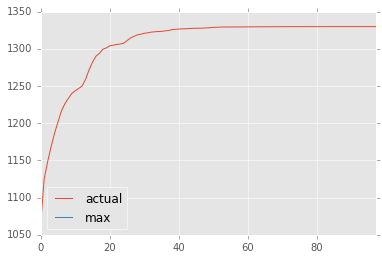

In [65]:
df = pd.DataFrame({'actual':_scores,
                   'max': np.repeat(num_students, len(_scores))})
df.plot()

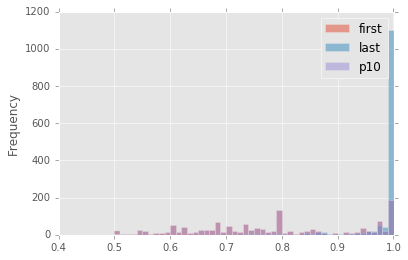

In [82]:
z = {}
for i,v in enumerate(_individual_scores):
    if i % 20 == 0:
        z[i] = v
df2 = pd.DataFrame({'first': _individual_scores[0],
                    'last': _individual_scores[-1],
                    'p10': _individual_scores[len(_individual_scores)//10]})
df2.plot(kind='hist', bins=50, alpha=0.5)

In [104]:
get_names([x for x in _ranking if company_counter[x] > 10])[:20]

['Palantir Technologies',
 'Twitter',
 'Microsoft',
 'Mozilla',
 'Google',
 'ContextLogic',
 'Facebook',
 'Electronic Arts',
 'A9.com',
 'Zynga',
 'Apple',
 'Christie Digital Systems',
 'Yelp',
 'Amazon',
 'LinkedIn',
 'McAfee',
 'Lookout',
 'NVIDIA',
 'Minted',
 'Bloomberg']